# Chapter: Reinforcement Learning


# Topic: RL Agent training and test

In [1]:
# import packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# define utility functions
def ActorNetwork(n_states=3, n_action=1):
    """
    Get actor network with the given parameters
    
    Arg:
        n_states: dimension of observation/state
        n_action: dimension of action
        
    Returns:
        the keras model
    """
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape=(n_states,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_action, activation='sigmoid'))
    
    return model

def CriticNetwork(n_states=3, n_action=1):
    """
    Get critic network with the given parameters
    
    Arg:
        n_states: dimension of observation/state
        n_action: dimension of action
        
    Returns:
        the keras model
    """
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape=(n_states+n_action,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    
    return model

def update_target(target_network, ref_network, tau=0.01):
    """
    update target network weights
    """
    
    target_network_weights = target_network.get_weights()
    ref_network_weights = ref_network.get_weights()
    
    for index in range(len(target_network_weights)):
        target_network_weights[index] = tau*ref_network_weights[index] + (1-tau)*target_network_weights[index]   
    target_network.set_weights(target_network_weights)
    
    return target_network

def OU_noise(noise_prev, theta=0.15, mu=0, sigma=0.025, n_action=1):
    """
    # adapted from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
    
    Simulate OU process to generate time-correlated noise
    """
    
    noise = noise_prev + theta*(mu-noise_prev) + sigma*np.random.randn(n_action)
    return noise

def sample_ReplayMemory():
    """
    # adapted from https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb

    Returns:
        states: A 2D numpy array with 3 columns 
        actions: A 2D numpy array with 1 column
        rewards: A 1D numpy array
        next_states: A 2D numpy array with 3 columns
        dones: A 1D numpy array
    
    """
    # select a batch of transitions from the replay memory
    indices = np.random.randint(len(replay_memory), size=batchSize)
    batch = [replay_memory[index] for index in indices]
    
    # separate the states, actions, rewards, next_states, dones from the selected transitions
    states, actions, rewards, next_states, dones = [np.array([transition[field_index] for transition in batch]) for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def get_TD_targets(rewards, target_Q_values, dones, gamma=0.95):
    """
    Args:
        rewards: A 1D numpy array
        target_Q_values: A 2D numpy array with 1 column
        dones: A 1D numpy array
    
    Returns: 
        td_targets: A 2D numpy array with 1 column 
    """
    td_targets = np.zeros_like(target_Q_values)
    for i in range(target_Q_values.shape[0]):
        if dones[i]:
            td_targets[i] = rewards[i]
        else:
            td_targets[i] = rewards[i] + gamma*target_Q_values[i]
    
    return td_targets

# tf.function used for improved performance
@tf.function(
    input_signature=[
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
    ])
def ddpg_updateStep(s, a, td_targets):
    """
    Update the main networks 
    """
    # update critic
    with tf.GradientTape() as tape:
        Q_predicted = critic(tf.concat([s, a], 1))
        critic_loss = tf.reduce_mean(loss_fn(td_targets, Q_predicted)) # loss_fn is defined later
    critic_gradients = tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))
    
    # update actor
    with tf.GradientTape() as tape:
        actor_loss = -tf.reduce_mean(critic(tf.concat([s, actor(s)], 1)))
    actor_gradients = tape.gradient(actor_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_gradients, actor.trainable_variables))


In [3]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                   RL Agent training
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [6]:
# some initializations

# define replay memory
from collections import deque
replay_memory = deque(maxlen=100000)

# define networks and set their optimizers
critic = CriticNetwork()
target_critic = CriticNetwork()
target_critic.set_weights(critic.get_weights())

actor = ActorNetwork()
target_actor = ActorNetwork()
target_actor.set_weights(actor.get_weights())

critic_optimizer = keras.optimizers.Adam(lr=0.01)
actor_optimizer = keras.optimizers.Adam(lr=0.01)

loss_fn = keras.losses.MeanSquaredError()

# define environment
from Tank_Environment import tank_environment
env = tank_environment() # __init__ function gets called implicitly here

# some training settings
rewards = [] # stores the total reward collected over each episode
n_episodes = 300
n_steps = 200
batchSize = 64

In [ ]:
# the training loop
for episode in range(n_episodes):
    state = env.reset()
    noise = 0
    episode_reward = 0
    
    for step in range(n_steps):
        # determine action
        action = actor.predict(state.reshape(1,-1)).flatten()
        noise = OU_noise(noise)
        action = np.clip(action + noise, 0, 1) # ensuring action remains within 0 and 1
        
        # implement action, get back new state and reward, and save in RM
        next_state, reward, done = env.step(action[0])
        episode_reward = episode_reward + reward
        replay_memory.append((state, action, reward, next_state, done))
        
        # update the networks
        if len(replay_memory) >= batchSize:
            # sample transitions
            RM_states, RM_actions, RM_rewards, RM_next_states, RM_dones = sample_ReplayMemory()
            
            # compute TD targets
            RM_target_next_actions = target_actor.predict(RM_next_states)
            RM_target_Q_values = target_critic.predict(np.concatenate((RM_next_states, RM_target_next_actions), axis=1))
            RM_td_targets = get_TD_targets(RM_rewards, RM_target_Q_values, RM_dones)
            
            # update main networks
            ddpg_updateStep(tf.convert_to_tensor(RM_states, dtype=tf.float32), 
                            tf.convert_to_tensor(RM_actions, dtype=tf.float32),
                            tf.convert_to_tensor(RM_td_targets, dtype=tf.float32))
            
            # update target networks
            target_critic = update_target(target_critic, critic)
            target_actor = update_target(target_actor, actor)
        
        # preparation for next step
        state = next_state
        if done:
            break
    
    rewards.append(episode_reward)
    print('Episode{} steps{} reward={}'.format(episode, step, episode_reward))

In [ ]:
# plot training rewards
import matplotlib.pyplot as plt
plt.figure()
plt.plot(rewards)
plt.xlabel('episode #'), plt.ylabel('episode reward')

# plot moving average reward of 50 episodes
import pandas as pd
rewards_series = pd.Series(rewards)
MA_rewards = rewards_series.rolling(10).mean()

plt.figure()
plt.plot(MA_rewards)
plt.xlabel('episode #'), plt.ylabel('MA episodic reward')

plt.show()

In [ ]:
# save the models
actor.save('actor_saved')

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#                   RL Agent test
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
distFlow_fileName = 'disturbance_200.csv'
distFlow = np.loadtxt(distFlow_fileName, delimiter=',')

env = tank_environment(pre_def_dist=True, pre_distFlow=distFlow)
state = env.reset()

level_hist = []
valve_opening_hist = []

actor = keras.models.load_model('actor_saved')
for step in range(n_steps):
    # take action
    action = actor.predict(state.reshape(1,-1)).flatten()
    valve_opening_hist.append(action[0])
    
    # implement action, get back new state and reward
    next_state, reward, done = env.step_test(action[0], step)
    
    # store
    level_hist.append(next_state[0]*env.height)
    
    # check termination
    if done:
        break
    else:
       state =  next_state

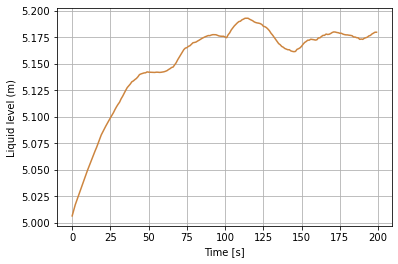

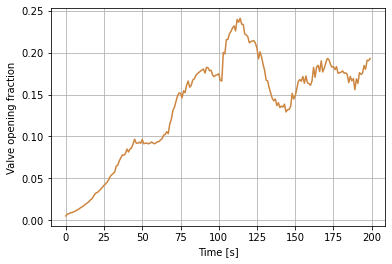

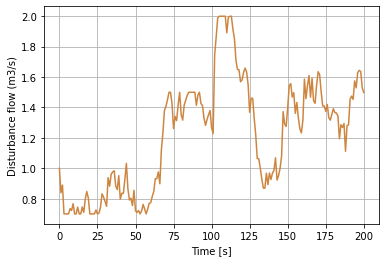

In [10]:
# plots
import matplotlib.pyplot as plt

plt.figure()
plt.plot(level_hist, color='peru')
plt.ylabel('Liquid level (m)')
plt.xlabel('Time [s]')
plt.grid()

plt.figure()
plt.plot(valve_opening_hist, color='peru')
plt.ylabel('Valve opening fraction')
plt.xlabel('Time [s]')
plt.grid()

plt.figure()
plt.plot(distFlow, color='peru')
plt.ylabel('Disturbance flow (m3/s)')
plt.xlabel('Time [s]')
plt.grid()

plt.show()